## IBM Data Science Professional

Applied Data Science Capstone, Chris Gray, September 2020

First, let's import the necessary libraries...

In [25]:
import itertools
import numpy as np
import pylab as pl
import pandas as pd

### Data understanding:
In this phase, you need to collect or extract the dataset from various sources such as csv file or SQL database. Then, you need to determine the attributes (columns) that you will use to train your machine learning model. Also, you will assess the condition of chosen attributes by looking for trends, certain patterns, skewed information, correlations, and so on.

In [26]:
!wget -O Data-Collisions.csv https://raw.githubusercontent.com/chrisgray40/Coursera_Capstone/master/Data-Collisions.csv
df = pd.read_csv('Data-Collisions.csv', error_bad_lines=False)

--2020-09-13 13:55:41--  https://raw.githubusercontent.com/chrisgray40/Coursera_Capstone/master/Data-Collisions.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72431093 (69M) [text/plain]
Saving to: ‘Data-Collisions.csv’

100%[======================================>] 72,431,093   152MB/s   in 0.5s   

2020-09-13 13:55:42 (152 MB/s) - ‘Data-Collisions.csv’ saved [72431093/72431093]



In [27]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


First things first: Severity Code, our target variable

In [28]:
df['SEVERITYCODE'].value_counts(dropna=False)


1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

Since we really care about 2 - bodily injury, let's recode to 0, 1

In [29]:
df['SEVERITYCODE'].replace(to_replace=1, value=0, inplace=True)
df['SEVERITYCODE'].replace(to_replace=2, value=1, inplace=True)
df['SEVERITYCODE'].value_counts(dropna=False)

0    136485
1     58188
Name: SEVERITYCODE, dtype: int64

Let's start by looking at Address type. Does this have any impact on our Severity Score?

In [30]:
# Address Type
df['ADDRTYPE'].value_counts(dropna=False)


Block           126926
Intersection     65070
NaN               1926
Alley              751
Name: ADDRTYPE, dtype: int64

In [31]:
df.groupby(['ADDRTYPE'])['SEVERITYCODE'].value_counts(normalize=True)

ADDRTYPE      SEVERITYCODE
Alley         0               0.890812
              1               0.109188
Block         0               0.762885
              1               0.237115
Intersection  0               0.572476
              1               0.427524
Name: SEVERITYCODE, dtype: float64

Yes, it does! Intersections are much more dangerous than alleys. This could easily be a function of speed.

Let's move on to Collision Type

In [32]:
# Collision Type
df['COLLISIONTYPE'].value_counts(dropna=False)

Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
NaN            4904
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64

In [33]:
df.groupby(['COLLISIONTYPE'])['SEVERITYCODE'].value_counts(normalize=True)

COLLISIONTYPE  SEVERITYCODE
Angles         0               0.607083
               1               0.392917
Cycles         1               0.876085
               0               0.123915
Head On        0               0.569170
               1               0.430830
Left Turn      0               0.605123
               1               0.394877
Other          0               0.742142
               1               0.257858
Parked Car     0               0.944527
               1               0.055473
Pedestrian     1               0.898305
               0               0.101695
Rear Ended     0               0.569639
               1               0.430361
Right Turn     0               0.793978
               1               0.206022
Sideswipe      0               0.865334
               1               0.134666
Name: SEVERITYCODE, dtype: float64

Definite trends with Collision type. It appears that collisions at angles, head on, left turn, and rear end lead to the most severe crashes.
Cycles, sideswipes, etc are less dangerous

Moving on to Person Count

In [34]:
# Person Count
df['PERSONCOUNT'].value_counts(dropna=False)

2     114231
3      35553
4      14660
1      13154
5       6584
0       5544
6       2702
7       1131
8        533
9        216
10       128
11        56
12        33
13        21
14        19
15        11
17        11
16         8
44         6
18         6
20         6
25         6
19         5
26         4
22         4
27         3
28         3
29         3
47         3
32         3
34         3
37         3
23         2
21         2
24         2
30         2
36         2
57         1
31         1
35         1
39         1
41         1
43         1
48         1
53         1
54         1
81         1
Name: PERSONCOUNT, dtype: int64

Pretty big spread of persons here. Let's group into 1, 2, 3, 4, and 5+ 

In [35]:
df['PERSONCOUNT'].where(df['PERSONCOUNT'] < 5,5,inplace=True)
df['PERSONCOUNT'].value_counts(dropna=False)

2    114231
3     35553
4     14660
1     13154
5     11531
0      5544
Name: PERSONCOUNT, dtype: int64

In [36]:
from scipy import stats
pearson_coef, p_value = stats.pearsonr(df['PERSONCOUNT'], df['SEVERITYCODE'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.14719105647071537  with a P-value of P = 0.0


Clear trend here that the more people involved, the higher the severity. 

Moving on, looking at Number of Pedestrians:

In [37]:
# Ped Count
df['PEDCOUNT'].value_counts(dropna=False)

0    187734
1      6685
2       226
3        22
4         4
6         1
5         1
Name: PEDCOUNT, dtype: int64

In [38]:
df.groupby(['PEDCOUNT'])['SEVERITYCODE'].value_counts(normalize=True)

PEDCOUNT  SEVERITYCODE
0         0               0.723295
          1               0.276705
1         1               0.898579
          0               0.101421
2         1               0.915929
          0               0.084071
3         1               0.954545
          0               0.045455
4         1               1.000000
5         1               1.000000
6         1               1.000000
Name: SEVERITYCODE, dtype: float64

In [39]:
pearson_coef, p_value = stats.pearsonr(df['PEDCOUNT'], df['SEVERITYCODE'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.24633815772800452  with a P-value of P = 0.0


Wow. Involving a single pedestrian makes the severity rate absolutely skyrocket. Let's create an indicator for "0 pedestrians" in addition to the continuous field.

In [40]:
df['PEDCOUNT_0'] = 0
df.loc[df['PEDCOUNT'] >= 1, ['PEDCOUNT_0']] = 1
df.groupby(['PEDCOUNT'])['PEDCOUNT_0'].value_counts(normalize=True)

PEDCOUNT  PEDCOUNT_0
0         0             1.0
1         1             1.0
2         1             1.0
3         1             1.0
4         1             1.0
5         1             1.0
6         1             1.0
Name: PEDCOUNT_0, dtype: float64

In [41]:
pearson_coef, p_value = stats.pearsonr(df['PEDCOUNT_0'], df['SEVERITYCODE'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.25219835429145654  with a P-value of P = 0.0


Let's look at number of Cyclists...

In [42]:
# Cycle Count
df['PEDCYLCOUNT'].value_counts(dropna=False)

0    189189
1      5441
2        43
Name: PEDCYLCOUNT, dtype: int64

In [43]:
df.groupby(['PEDCYLCOUNT'])['SEVERITYCODE'].value_counts(normalize=True)

PEDCYLCOUNT  SEVERITYCODE
0            0               0.717832
             1               0.282168
1            1               0.875207
             0               0.124793
2            1               1.000000
Name: SEVERITYCODE, dtype: float64

In [44]:
pearson_coef, p_value = stats.pearsonr(df['PEDCYLCOUNT'], df['SEVERITYCODE'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.21421818271572407  with a P-value of P = 0.0


And the same is true with Cyclists. Funnily enough, when a car hits a person or a bike, it doesn't end well. Since there are so few with 2 cyclists, let's lump them into the "1" category

In [45]:
df['PEDCYLCOUNT'].replace(to_replace=2, value=1, inplace=True)
df.groupby(['PEDCYLCOUNT'])['SEVERITYCODE'].value_counts(normalize=True)

PEDCYLCOUNT  SEVERITYCODE
0            0               0.717832
             1               0.282168
1            1               0.876185
             0               0.123815
Name: SEVERITYCODE, dtype: float64

Moving on to Vehicle Count

In [46]:
# Vehicle Count
df['VEHCOUNT'].value_counts(dropna=False)


2     147650
1      25748
3      13010
0       5085
4       2426
5        529
6        146
7         46
8         15
9          9
11         6
10         2
12         1
Name: VEHCOUNT, dtype: int64

Small sample sizes here above 5 cars, so let's bin them like we did earlier

In [47]:
df['VEHCOUNT'].where(df['VEHCOUNT'] < 5,5,inplace=True)
df['VEHCOUNT'].value_counts(dropna=False)

2    147650
1     25748
3     13010
0      5085
4      2426
5       754
Name: VEHCOUNT, dtype: int64

In [48]:
df.groupby(['VEHCOUNT'])['SEVERITYCODE'].value_counts(normalize=True)

VEHCOUNT  SEVERITYCODE
0         0               0.758702
          1               0.241298
1         1               0.547810
          0               0.452190
2         0               0.756526
          1               0.243474
3         0               0.579554
          1               0.420446
4         0               0.555647
          1               0.444353
5         0               0.523873
          1               0.476127
Name: SEVERITYCODE, dtype: float64

In [49]:
pearson_coef, p_value = stats.pearsonr(df['VEHCOUNT'], df['SEVERITYCODE'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.05694279764587654  with a P-value of P = 1.6269780702027183e-139


It's not clear if there is a trend here, and correlation coefficient is very low. Let's leave it out.

Moving on to Junction Type

In [50]:
# Junction Type
df['JUNCTIONTYPE'].value_counts(dropna=False)

Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
NaN                                                   6329
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
Name: JUNCTIONTYPE, dtype: int64

In [51]:
df.groupby(['JUNCTIONTYPE'])['SEVERITYCODE'].value_counts(normalize=True)

JUNCTIONTYPE                                       SEVERITYCODE
At Intersection (but not related to intersection)  0               0.703051
                                                   1               0.296949
At Intersection (intersection related)             0               0.567362
                                                   1               0.432638
Driveway Junction                                  0               0.696936
                                                   1               0.303064
Mid-Block (but intersection related)               0               0.679816
                                                   1               0.320184
Mid-Block (not related to intersection)            0               0.783920
                                                   1               0.216080
Ramp Junction                                      0               0.674699
                                                   1               0.325301
Unknown                 

Its not clear there's anything happening with Junction Type. This will not go into the model

SDOT Collision codes

In [52]:
df.groupby(['SDOT_COLCODE'])['SEVERITYCODE'].value_counts(normalize=True)

SDOT_COLCODE  SEVERITYCODE
0             0               0.927659
              1               0.072341
11            0               0.714373
              1               0.285627
12            0               0.981250
              1               0.018750
13            0               0.965995
              1               0.034005
14            0               0.673143
              1               0.326857
15            0               0.953242
              1               0.046758
16            0               0.930298
              1               0.069702
18            1               0.880799
              0               0.119201
21            1               0.773481
              0               0.226519
22            1               0.941176
              0               0.058824
23            1               0.750000
              0               0.250000
24            1               0.897975
              0               0.102025
25            0               0.80392

Lots of variety here, however we're also dealing with small sample sizes and an overload of categories. There is a potential unbalanced model concern with this variable

Inattention

In [53]:
# Inattention
df['INATTENTIONIND'].value_counts(dropna=False)

# Recode Nan/Y vars to 0/1
df['INATTENTIONIND'].replace(to_replace='Y', value=1, inplace=True)
df['INATTENTIONIND'] = df['INATTENTIONIND'].fillna(0)

df['INATTENTIONIND'].value_counts(dropna=False)

0.0    164868
1.0     29805
Name: INATTENTIONIND, dtype: int64

In [54]:
df.groupby(['INATTENTIONIND'])['SEVERITYCODE'].value_counts(normalize=True)

INATTENTIONIND  SEVERITYCODE
0.0             0               0.710126
                1               0.289874
1.0             0               0.651166
                1               0.348834
Name: SEVERITYCODE, dtype: float64

In [55]:
pearson_coef, p_value = stats.pearsonr(df['INATTENTIONIND'], df['SEVERITYCODE'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.04637771113288977  with a P-value of P = 3.706252804903865e-93


Inattentive drivers are only marginally more likely to cause bodily harm, though it does appear to be statistically significant. This will go into the model

What about drunk driving?

In [56]:
# Under Influence
df['UNDERINFL'].value_counts(dropna=False)

# Recode N/Y vars to 0/1
df['UNDERINFL'].replace(to_replace='N', value=0, inplace=True)
df['UNDERINFL'].replace(to_replace='0', value=0, inplace=True)
df['UNDERINFL'].replace(to_replace='Y', value=1, inplace=True)
df['UNDERINFL'].replace(to_replace='1', value=1, inplace=True)
df['UNDERINFL'] = df['UNDERINFL'].fillna(0)

df['UNDERINFL'].value_counts(dropna=False)

0.0    185552
1.0      9121
Name: UNDERINFL, dtype: int64

In [57]:
df.groupby(['UNDERINFL'])['SEVERITYCODE'].value_counts(normalize=True)

UNDERINFL  SEVERITYCODE
0.0        0               0.705603
           1               0.294397
1.0        0               0.609473
           1               0.390527
Name: SEVERITYCODE, dtype: float64

In [58]:
pearson_coef, p_value = stats.pearsonr(df['UNDERINFL'], df['SEVERITYCODE'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.0443766229171993  with a P-value of P = 1.908982071929083e-85


Yes, drunk drivers appear to be more likely to cause harm. Into the model it goes.

Does the weather matter?

In [59]:
df.groupby(['WEATHER'])['SEVERITYCODE'].value_counts(normalize=True)

WEATHER                   SEVERITYCODE
Blowing Sand/Dirt         0               0.732143
                          1               0.267857
Clear                     0               0.677509
                          1               0.322491
Fog/Smog/Smoke            0               0.671353
                          1               0.328647
Other                     0               0.860577
                          1               0.139423
Overcast                  0               0.684456
                          1               0.315544
Partly Cloudy             1               0.600000
                          0               0.400000
Raining                   0               0.662815
                          1               0.337185
Severe Crosswind          0               0.720000
                          1               0.280000
Sleet/Hail/Freezing Rain  0               0.752212
                          1               0.247788
Snowing                   0               0

Weather doesn't actually appear to make that much of a difference. We'll leave this one out of the model.

What about the road conditions? After all, that is more directly relevent to driving

In [60]:
df.groupby(['ROADCOND'])['SEVERITYCODE'].value_counts(normalize=True)

ROADCOND        SEVERITYCODE
Dry             0               0.678227
                1               0.321773
Ice             0               0.774194
                1               0.225806
Oil             0               0.625000
                1               0.375000
Other           0               0.674242
                1               0.325758
Sand/Mud/Dirt   0               0.693333
                1               0.306667
Snow/Slush      0               0.833665
                1               0.166335
Standing Water  0               0.739130
                1               0.260870
Unknown         0               0.950325
                1               0.049675
Wet             0               0.668134
                1               0.331866
Name: SEVERITYCODE, dtype: float64

Some strange results here. For example "unknown" road conditions only have a 5% severity rate. I'm not sure what that could mean. This will stay out of the model

Let's move on to light conditions

In [61]:
# Light Conditions
df['LIGHTCOND'].value_counts(dropna=False)

Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
NaN                           5170
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

In [62]:
df.groupby(['LIGHTCOND'])['SEVERITYCODE'].value_counts(normalize=True)

LIGHTCOND                 SEVERITYCODE
Dark - No Street Lights   0               0.782694
                          1               0.217306
Dark - Street Lights Off  0               0.736447
                          1               0.263553
Dark - Street Lights On   0               0.701589
                          1               0.298411
Dark - Unknown Lighting   0               0.636364
                          1               0.363636
Dawn                      0               0.670663
                          1               0.329337
Daylight                  0               0.668116
                          1               0.331884
Dusk                      0               0.670620
                          1               0.329380
Other                     0               0.778723
                          1               0.221277
Unknown                   0               0.955095
                          1               0.044905
Name: SEVERITYCODE, dtype: float64

Again, it's not particularly clear.

Was right of way not granted?

In [63]:
# Right of way not granted?
df['PEDROWNOTGRNT'].value_counts(dropna=False)

# Recode N/Y vars to 0/1
df['PEDROWNOTGRNT'].replace(to_replace='Y', value=1, inplace=True)
df['PEDROWNOTGRNT'] = df['PEDROWNOTGRNT'].fillna(0)

df['PEDROWNOTGRNT'].value_counts(dropna=False)

0.0    190006
1.0      4667
Name: PEDROWNOTGRNT, dtype: int64

In [64]:
df.groupby(['PEDROWNOTGRNT'])['SEVERITYCODE'].value_counts(normalize=True)

PEDROWNOTGRNT  SEVERITYCODE
0.0            0               0.715898
               1               0.284102
1.0            1               0.901436
               0               0.098564
Name: SEVERITYCODE, dtype: float64

In [65]:
pearson_coef, p_value = stats.pearsonr(df['PEDROWNOTGRNT'], df['SEVERITYCODE'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.2062830849988825  with a P-value of P = 0.0


Winner winner chicken dinner. in 90% of cases where the right of way was not granted, there was an injury. This is likely tied into the type of collision.

Does speeding matter?

In [66]:
# Speeding
df['SPEEDING'].value_counts(dropna=False)

# Recode N/Y vars to 0/1
df['SPEEDING'].replace(to_replace='Y', value=1, inplace=True)
df['SPEEDING'] = df['SPEEDING'].fillna(0)

df['SPEEDING'].value_counts(dropna=False)

0.0    185340
1.0      9333
Name: SPEEDING, dtype: int64

In [67]:
df.groupby(['SPEEDING'])['SEVERITYCODE'].value_counts(normalize=True)

SPEEDING  SEVERITYCODE
0.0       0               0.705099
          1               0.294901
1.0       0               0.621665
          1               0.378335
Name: SEVERITYCODE, dtype: float64

In [68]:
pearson_coef, p_value = stats.pearsonr(df['SPEEDING'], df['SEVERITYCODE'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.038938339201815754  with a P-value of P = 3.3407402652562895e-66


It appears it matters, at least a little - speeders are 8 percentage points more likely to cause injuries. We'll include this

Does the State Collision Code matter?

In [69]:
df.groupby(['ST_COLDESC'])['SEVERITYCODE'].value_counts(normalize=True)

ST_COLDESC                                                                             SEVERITYCODE
All Other Multi Vehicle                                                                0               0.625000
                                                                                       1               0.375000
All other non-collision                                                                0               0.703704
                                                                                       1               0.296296
Breakage of any part of the vehicle resulting in injury or in further property damage  0               0.735294
                                                                                       1               0.264706
Domestic animal other (cat, dog, etc)                                                  0               0.937500
                                                                                       1               0.062500
Ente

Probably somewhat, but we're dealing with the same small sample size / too many categories issues that we dealt with with the SDOT data. This will not go into the model

Last but not least : Did the driver hit a parked car?

In [70]:
# Hit Parked Car
df['HITPARKEDCAR'].value_counts(dropna=False)

# Recode N/Y vars to 0/1
df['HITPARKEDCAR'].replace(to_replace='Y', value=1, inplace=True)
df['HITPARKEDCAR'].replace(to_replace='N', value=0, inplace=True)
df['HITPARKEDCAR'] = df['HITPARKEDCAR'].fillna(0)

df['HITPARKEDCAR'].value_counts(dropna=False)

0    187457
1      7216
Name: HITPARKEDCAR, dtype: int64

In [71]:
df.groupby(['HITPARKEDCAR'])['SEVERITYCODE'].value_counts(normalize=True)

HITPARKEDCAR  SEVERITYCODE
0             0               0.691983
              1               0.308017
1             0               0.937916
              1               0.062084
Name: SEVERITYCODE, dtype: float64

In [72]:
pearson_coef, p_value = stats.pearsonr(df['HITPARKEDCAR'], df['SEVERITYCODE'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.10149784205882276  with a P-value of P = 0.0


Clearly important. If you hit a parked car, you probably didn't do too much bodily harm. This will definitely go in the model.

### Data Preparation:
The data preparation includes all the required activities to construct the final dataset which will be fed into the modeling tools. Data preparation can be performed multiple times and it includes balancing the labeled data, transformation, filling missing data, and cleaning the dataset.

First: we're looking for determinants of bodily injury, however this group is undersampled in the dataset. So let's upsample SEVERITYCODE=1 to get more of a robust sample

In [73]:
df['SEVERITYCODE'].value_counts(dropna=False)

# change the weighting to over-sample serious injuries

# Model for resampling
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.SEVERITYCODE==0]
df_minority = df[df.SEVERITYCODE==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=136485,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['SEVERITYCODE'].value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

1    136485
0    136485
Name: SEVERITYCODE, dtype: int64

Select the Feature Set..

In [74]:
Feature = df_upsampled[['INATTENTIONIND','UNDERINFL','PEDROWNOTGRNT','SPEEDING','HITPARKEDCAR','PEDCOUNT','PEDCOUNT_0','PERSONCOUNT','PEDCYLCOUNT']]

In [75]:
Feature = pd.concat([Feature,pd.get_dummies(df_upsampled['ADDRTYPE'])], axis=1)
Feature.drop(['Alley'], axis = 1,inplace=True)

Feature = pd.concat([Feature,pd.get_dummies(df_upsampled['COLLISIONTYPE'])], axis=1)
Feature.drop(['Angles'], axis = 1,inplace=True)

X = Feature

In [76]:
# Normalize the X data
from sklearn import preprocessing
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


array([[-0.43670817, -0.23070007, -0.1993071 , -0.23296354, -0.17180232,
        -0.23902672, -0.24502348, -0.42390388, -0.21526527,  0.79576403,
        -0.77730655, -0.21369548, -0.10868854, -0.28744689, -0.36356721,
        -0.4819729 , -0.23852175, -0.49508953, -0.1191811 ,  3.37053891],
       [-0.43670817, -0.23070007, -0.1993071 , -0.23296354, -0.17180232,
        -0.23902672, -0.24502348,  1.45106944, -0.21526527,  0.79576403,
        -0.77730655, -0.21369548, -0.10868854, -0.28744689, -0.36356721,
         2.07480544, -0.23852175, -0.49508953, -0.1191811 , -0.29668846],
       [-0.43670817, -0.23070007, -0.1993071 , -0.23296354, -0.17180232,
        -0.23902672, -0.24502348,  0.51358278, -0.21526527,  0.79576403,
        -0.77730655, -0.21369548, -0.10868854, -0.28744689,  2.75052304,
        -0.4819729 , -0.23852175, -0.49508953, -0.1191811 , -0.29668846],
       [-0.43670817, -0.23070007, -0.1993071 , -0.23296354, -0.17180232,
        -0.23902672, -0.24502348, -0.42390388, -

In [77]:
# Set the target variable
y = df_upsampled['SEVERITYCODE'].values

Because the dataset is relatively large, we're going to Train/Test with a very very small training set (1%) just to select the right model. Once optimized, we'll then train on a much larger set.

In [78]:
# Split the datasets into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.995, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (1364, 20) (1364,)
Test set: (271606, 20) (271606,)


### Modeling:
In this phase, various algorithms and methods can be selected and applied to build the model including supervised machine learning techniques. You can select SVM, XGBoost, decision tree, or any other techniques. You can select a single or multiple machine learning models for the same data mining problem. At this phase, stepping back to the data preparation phase is often required.

### Model 1: K Nearest Neighbor (KNN)

In [79]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

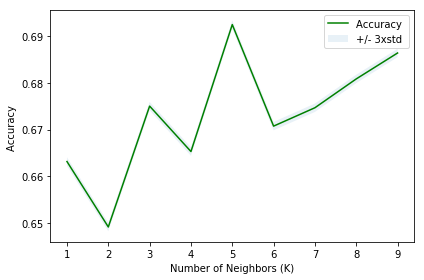

The best accuracy was with 0.6924294750484157 with k= 5


In [81]:
import matplotlib.pyplot as plt
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [82]:
k = 5
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh
yhat1 = neigh.predict(X_test)
yhat1[0:5]

array([0, 0, 1, 0, 1])

In [83]:
# Add a confusion matrix for KNN
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [84]:
from sklearn.metrics import classification_report, confusion_matrix, jaccard_similarity_score, f1_score, log_loss

              precision    recall  f1-score   support

           0       0.75      0.58      0.65    135821
           1       0.66      0.80      0.72    135785

   micro avg       0.69      0.69      0.69    271606
   macro avg       0.70      0.69      0.69    271606
weighted avg       0.70      0.69      0.69    271606

Normalized confusion matrix
[[0.58 0.42]
 [0.2  0.8 ]]


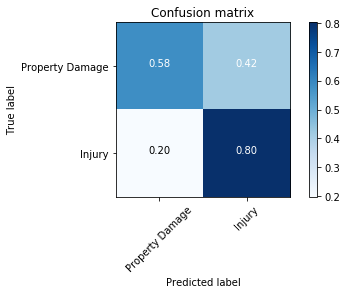

In [85]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat1)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Property Damage','Injury'],normalize= True,  title='Confusion matrix')

### Model 2: Decision Tree

In [86]:
from sklearn.tree import DecisionTreeClassifier

Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
Tree # it shows the default parameters

Tree.fit(X_train,y_train)

yhat2 = Tree.predict(X_test)

print (yhat2 [0:10])
print (y_test [0:10])

[0 1 1 0 0 0 1 1 1 0]
[0 0 1 0 0 1 1 1 1 0]


              precision    recall  f1-score   support

           0       0.63      0.75      0.69    135821
           1       0.69      0.57      0.63    135785

   micro avg       0.66      0.66      0.66    271606
   macro avg       0.66      0.66      0.66    271606
weighted avg       0.66      0.66      0.66    271606

Normalized confusion matrix
[[0.75 0.25]
 [0.43 0.57]]


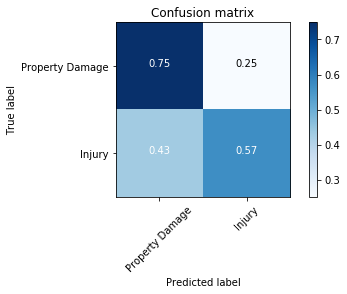

In [87]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat2)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat2))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Property Damage','Injury'],normalize= True,  title='Confusion matrix')

### Model 3: Support Vector Machine

In [88]:
from sklearn import svm

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

yhat3 = clf.predict(X_test)
yhat3 [0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([0, 0, 1, 0, 1])

              precision    recall  f1-score   support

           0       0.76      0.57      0.65    135821
           1       0.66      0.82      0.73    135785

   micro avg       0.70      0.70      0.70    271606
   macro avg       0.71      0.70      0.69    271606
weighted avg       0.71      0.70      0.69    271606

Normalized confusion matrix
[[0.57 0.43]
 [0.18 0.82]]


0.6960818244074137

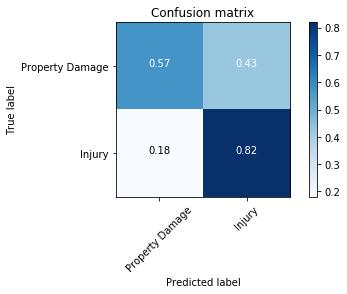

In [89]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat3)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat3))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Property Damage','Injury'],normalize= True,  title='Confusion matrix')

# F1 Score
f1_score(y_test, yhat3, average='weighted') 

# Jaccard
jaccard_similarity_score(y_test, yhat3)

### Model 4: Logistic Regression

[[ 82885  52936]
 [ 28123 107662]]
Normalized confusion matrix
[[0.61 0.39]
 [0.21 0.79]]


0.5582260823944383

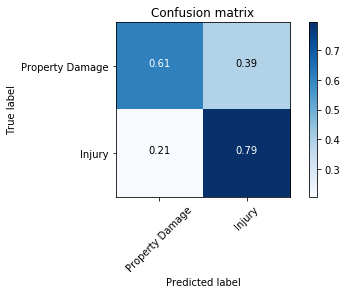

In [90]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

yhat4 = LR.predict(X_test)
yhat4

yhat4_prob = LR.predict_proba(X_test)
yhat4_prob

jaccard_similarity_score(y_test, yhat4)

print(confusion_matrix(y_test, yhat4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat4)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Property Damage','Injury'],normalize= True,  title='Confusion matrix')

from sklearn.metrics import log_loss
log_loss(y_test, yhat4_prob)

### Evaluation:
Before proceeding to the deployment stage, the model needs to be evaluated thoroughly to ensure that the business or the applications' objectives are achieved. Certain metrics can be used for the model evaluation such as accuracy, recall, F1-score, precision, and others.

In [92]:
print("Model: KNN")
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat1))
print("Test F1 Score: ", f1_score(y_test, yhat1, average='weighted'))
print("Test Jaccard Score: ", jaccard_similarity_score(y_test, yhat1))
print("")
print("Model: Decision Tree")
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat2))
print("Test F1 Score: ", f1_score(y_test, yhat2, average='weighted'))
print("Test Jaccard Score: ", jaccard_similarity_score(y_test, yhat2))
print("")
print("Model: SVM")
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat3))
print("Test F1 Score: ", f1_score(y_test, yhat3, average='weighted'))
print("Test Jaccard Score: ", jaccard_similarity_score(y_test, yhat3))
print("")
print("Model: Log Reg")
yhat4_prob = LR.predict_proba(X_test)
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat4))
print("Test F1 Score: ", f1_score(y_test, yhat4, average='weighted'))
print("Test Jaccard Score: ", jaccard_similarity_score(y_test, yhat4))
print("Test Log Loss Score: ", log_loss(y_test, yhat4_prob))

Model: KNN
Test set Accuracy:  0.6924294750484157
Test F1 Score:  0.6887280730181042
Test Jaccard Score:  0.6924294750484157

Model: Decision Tree
Test set Accuracy:  0.6589213787618831
Test F1 Score:  0.6561451258343262
Test Jaccard Score:  0.6589213787618831

Model: SVM
Test set Accuracy:  0.6960818244074137
Test F1 Score:  0.6913949817434024
Test Jaccard Score:  0.6960818244074137

Model: Log Reg
Test set Accuracy:  0.7015566666421214
Test F1 Score:  0.6990485923016758
Test Jaccard Score:  0.7015566666421214
Test Log Loss Score:  0.5582260823944383


### Deployment:
The deployment phase requirements vary from project to project. It can be as simple as creating a report, developing interactive visualization, or making the machine learning model available in the production environment. In this environment, the customers or end-users can utilize the model in different ways such as API, website, or so on.

In [93]:
# Split the datasets into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (218376, 20) (218376,)
Test set: (54594, 20) (54594,)


In [ ]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

yhat3 = clf.predict(X_test)
yhat3 [0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat3)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat3))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Property Damage','Injury'],normalize= True,  title='Confusion matrix')

# F1 Score
f1_score(y_test, yhat3, average='weighted') 

# Jaccard
jaccard_similarity_score(y_test, yhat3)